# Unbalanced Cell Type Alignment

```{note}
This notebook is a sample of what our applications chapter will look like when we fully release it. We're working hard on compiling all of our results to share with you!
```

In this notebook, we'll look at what happens when we systematically downsample one of our domains in an alignment problem (simulating a situtation where we only have separately assayed data). In particular, we'll systematically downsample by cell type in a PBMC co-assayed dataset that contains RNA-seq (gene expression) and ATAC-seq (open chromatin) data. For now, we have provided our preprocessed version of this dataset in smaller files in the GitHub repository of this book, although we plan on additionally sharing our preprocessing steps once we have them in a publishable format.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, fused formulation tutorials. We will draw on all of these when examining AGW.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you want to understand how to use AGW more generally, visit our AGW tutorial.
```

### Preprocessing

We can begin by loading in our data:

In [1]:
import pickle
import scanpy as sc
adt_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
rna_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
adt_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
rna_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(adt_raw.shape[1])]

In [3]:
import pandas as pd
from sklearn.preprocessing import normalize
# l2 normalization of both datasets, which we found to help with single cell applications
adt = pd.DataFrame(adt_raw.X.transpose())
rna = pd.DataFrame(rna_raw.X.transpose())

# annotation of both domains
adt.index, adt.columns = samp_labels, adt_feat_labels
rna.index, rna.columns = samp_labels, rna_feat_labels
rna.shape, adt.shape

((1000, 25), (1000, 25))

From here, we can randomly sample fractions of each domain to keep for the unbalanced case:

In [4]:
import random
from numpy.random import seed, permutation

random.seed(5)
adt_mod = adt.sample(frac=0.5 + 0.05*random.choice(range(0, 11, 1)), random_state=10)
rna_mod = rna.sample(frac=0.5 + 0.05*random.choice(range(0, 11, 1)), random_state=10)

random.seed(5)
adt_feat_mod = adt.sample(frac=0.52 + 0.04*random.choice(range(0, 13, 1)), random_state=10, axis=1)
rna_feat_mod = rna.sample(frac=0.52 + 0.04*random.choice(range(0, 13, 1)), random_state=10, axis=1)

# figure
adt_sfeat_mod = adt.iloc[:,:].iloc[:, :20]
rna_sfeat_mod = rna.iloc[:,:].iloc[:, :]

# figure
# adt_sfeat_mod = adt.iloc[:,:][["CD3", "CD4", "CD8", "CD2", "CD45RA", "CD57", "CD16", "CD14", "CD11c", "CD19"]]
# rna_sfeat_mod = rna.iloc[:,:][["CD3E", ""]]

In [5]:
# retrieving numeric matrices
adt_mtx_full = adt.iloc[:, :]
adt_mtx = adt_mod.iloc[:, :]
adt_feat_mtx = adt_feat_mod.iloc[:, :]
adt_sfeat_mtx = adt_sfeat_mod.iloc[:, :]

rna_mtx_full = rna.iloc[:, :]
rna_mtx = rna_mod.iloc[:, :]
rna_feat_mtx = rna_feat_mod.iloc[:, :]
rna_sfeat_mtx = rna_sfeat_mod.iloc[:, :]

Note that we can easily view the manner in which we downsampled our data:

In [6]:
adt_mod.shape, rna_mod.shape, adt_sfeat_mod.shape, rna_sfeat_mod.shape

((950, 25), (700, 25), (1000, 20), (1000, 25))

### Alignment Setup

Now, we can begin our usual SCOT+ workflow:

In [7]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

As usual, we normalize our data:

In [8]:
rna_mtx_full=normalize(rna_mtx_full)
adt_mtx_full=normalize(adt_mtx_full)
rna_mtx=normalize(rna_mtx)
adt_mtx=normalize(adt_mtx)
rna_feat_mtx=normalize(rna_feat_mtx)
adt_feat_mtx=normalize(adt_feat_mtx)
rna_sfeat_mtx=normalize(rna_sfeat_mtx)
adt_sfeat_mtx=normalize(adt_sfeat_mtx)
# don't need to normalize full data, as we already did above

And visualize it in two dimensions before alignment:

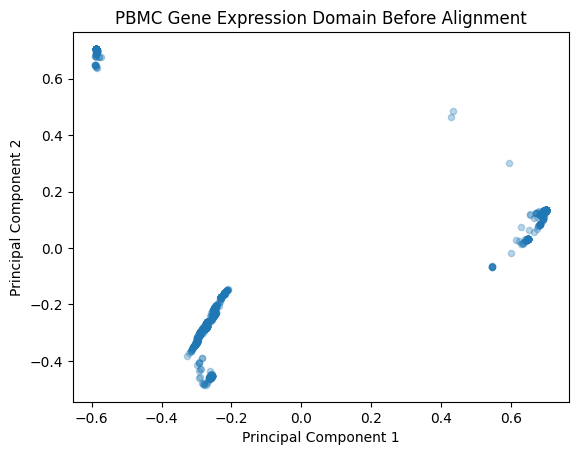

In [8]:
# visualize rna
import numpy as np

rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx_full)
rna_2Dpca = rna_pca.transform(rna_mtx_full)
plt.figure()

plt.scatter(rna_2Dpca[:, 0], rna_2Dpca[:, 1], s=20, alpha=0.3)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

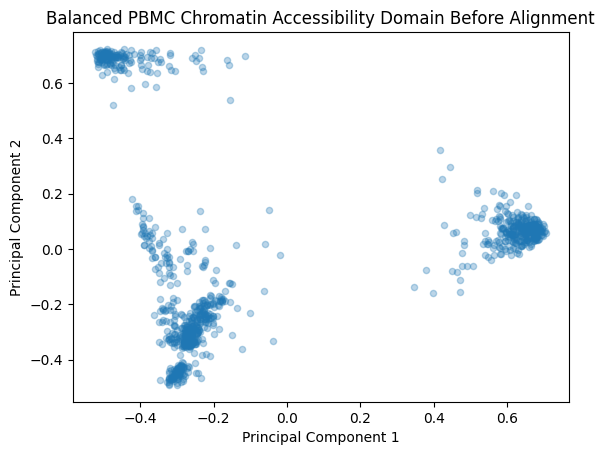

In [9]:
# visualize ATAC
import numpy as np

adt_pca=PCA(n_components=2)
adt_2Dpca=adt_pca.fit_transform(adt_mtx_full)
plt.figure()

plt.scatter(adt_2Dpca[:, 0], adt_2Dpca[:, 1], s=20, alpha=0.3)

# plt.legend(loc='best', shadow=False)
plt.title('Balanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

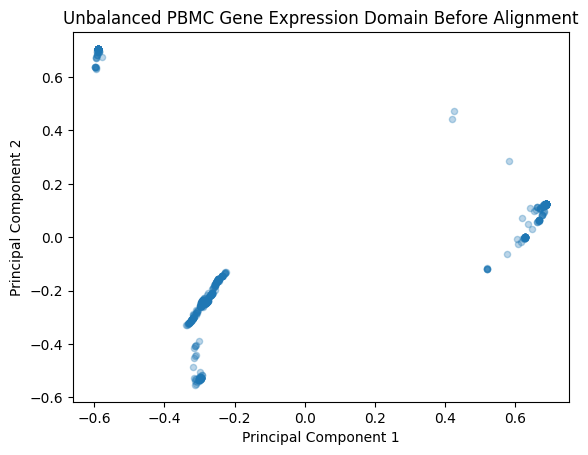

In [10]:
# visualize subsetted rna
import numpy as np

rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)
plt.figure()

plt.scatter(rna_2Dpca[:, 0], rna_2Dpca[:, 1], s=20, alpha=0.3)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

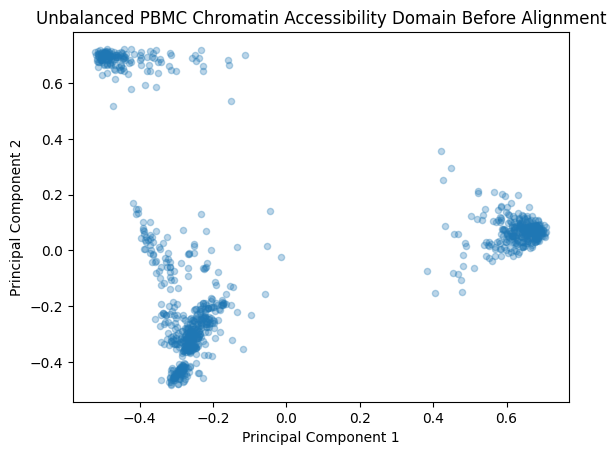

In [11]:
# visualize subsetted ATAC
import numpy as np

adt_pca=PCA(n_components=2)
adt_2Dpca=adt_pca.fit_transform(adt_mtx)
plt.figure()

plt.scatter(adt_2Dpca[:, 0], adt_2Dpca[:, 1], s=20, alpha=0.3)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Balanced

We can start by looking at the balanced alignment with GW:

In [311]:
# compute distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_rna = compute_graph_distances(rna_mtx_full, n_neighbors=100, mode='connectivity')
D_adt = compute_graph_distances(adt_mtx_full.astype('float32'), n_neighbors=100, mode='connectivity')

In [312]:
from scotplus.utils.alignment import get_barycentre, FOSCTTM

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=10)

# original grid search
# scores = pd.Series(index=pd.MultiIndex.from_product([[0.1, 0.15, 0.2, 0.25, 0.3], reversed([x for x in np.logspace(-3, -1, 10)])], names=["alpha", "eps"]), name="FOSCTTM")
# for alpha in [0.1, 0.15, 0.2, 0.25, 0.3]:
#     for eps in reversed([x for x in np.logspace(-3, -1, 10)]):
#         print(alpha, eps)
#         pi_samp,_,pi_feat = scot.agw(rna_mtx_full, adt_mtx_full, D_rna, D_adt, alpha=alpha, eps = eps, verbose = False)
#         aligned_rna = get_barycentre(adt_mtx_full, pi_samp)
#         scores.loc[(alpha, eps)] = np.mean(FOSCTTM(adt_mtx_full, aligned_rna))
# pickle.dump(scores, open(r"data/CITEseq/balanced_cite_scores_gsearch.pkl", mode='wb'))
scores = pickle.load(open(r"data/CITEseq/balanced_cite_scores_gsearch.pkl", mode='rb'))
alpha, eps = scores.idxmin()
pi_samp,_,pi_feat = scot.agw(rna_mtx_full, adt_mtx_full, D_rna, D_adt, alpha=alpha, eps = eps, verbose = False)
aligned_rna = get_barycentre(adt_mtx_full, pi_samp)
alpha, eps, np.mean(FOSCTTM(adt_mtx_full, aligned_rna))

(0.1, 0.0016681005372000592, 0.07717067067067067)

In [77]:
pickle.load(open(r"data/CITEseq/balanced_cite_scores_gsearch.pkl", mode='rb')).idxmin()

(0.1, 0.0016681005372000592)

In [ ]:
# uncomment when running balanced grid search
# import pickle
# pickle.dump(rna, open(r"data/CITEseq/balanced_orig_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(adt, open(r"data/CITEseq/balanced_orig_adt_cite_fig.pkl", mode='wb'))
# pickle.dump(pd.DataFrame(aligned_rna, columns=adt.columns, index=rna.index), open(r"data/CITEseq/balanced_aligned_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(pi_feat, open(r"data/CITEseq/balanced_feat_mtx.pkl", mode='wb'))

### Balanced Evaluation

In [338]:
rna_mtx_full = pickle.load(open(r"data/CITEseq/balanced_orig_rna_cite_fig.pkl", 'rb'))
adt_mtx_full = pickle.load(open(r"data/CITEseq/balanced_orig_adt_cite_fig.pkl", 'rb'))
aligned_rna = pickle.load(open(r"data/CITEseq/balanced_aligned_rna_cite_fig.pkl", 'rb'))
pi_feat = pickle.load(open(r"data/CITEseq/balanced_feat_mtx.pkl", mode='rb'))

rna_mtx_full.shape, adt_mtx_full.shape, aligned_rna.shape

((1000, 25), (1000, 25), (1000, 25))

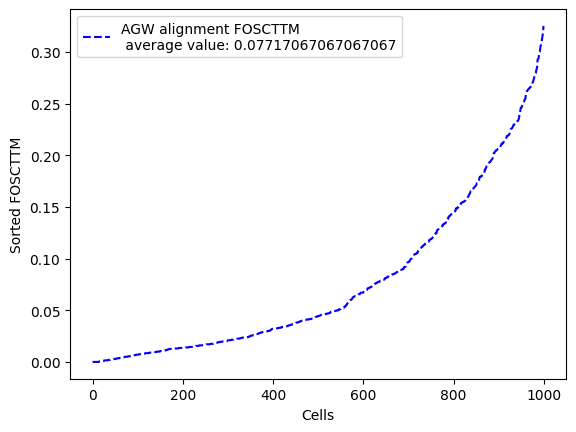

In [339]:
from scotplus.utils.alignment import FOSCTTM
fracs = FOSCTTM(adt_mtx_full, aligned_rna)
legend_label="AGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "b--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

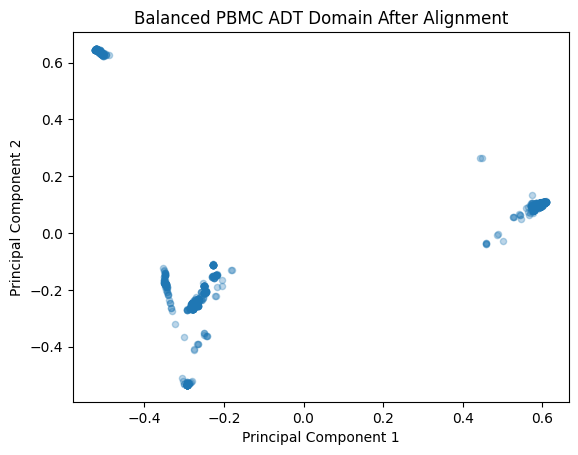

In [314]:
Xadt_integrated=adt_mtx_full
Yrna_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xadt_integrated,Yrna_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xadt_integrated_pc=concatenated_pc[0:Xadt_integrated.shape[0],:]
Yrna_subsamp_integrated_pc=concatenated_pc[Xadt_integrated.shape[0]:,:]

plt.scatter(Yrna_subsamp_integrated_pc[:, 0], Yrna_subsamp_integrated_pc[:, 1], s=20, alpha=0.3)
    
    
plt.title('Balanced PBMC ADT Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


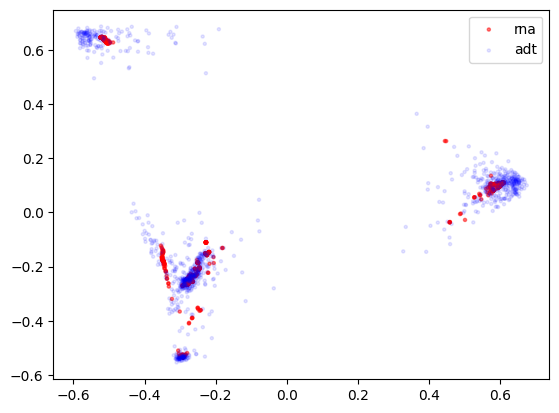

In [315]:
Xadt_integrated=adt_mtx_full
Yrna_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xadt_integrated,Yrna_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xadt_integrated_pc=concatenated_pc[0:Xadt_integrated.shape[0],:]
Yrna_subsamp_integrated_pc=concatenated_pc[Xadt_integrated.shape[0]:,:]

rna_labels = np.array(["rna" for _ in range(rna.shape[0])])
adt_labels = np.array(["adt" for _ in range(adt.shape[0])])
alphas = (np.hstack((np.ones_like(adt_labels, dtype=int)/10, np.ones_like(rna_labels, dtype=int)/2)))

for (label, color) in zip(["rna", "adt"], ['r', 'b']):
    mask = (np.hstack((adt_labels, rna_labels)) == label)
    plt.scatter(np.vstack((Xadt_integrated_pc, Yrna_subsamp_integrated_pc))[mask, 0], np.vstack((Xadt_integrated_pc, Yrna_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()


### Unbalanced

In [316]:
# compute new distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_urna = compute_graph_distances(rna_mtx.astype('float32'), n_neighbors=100, mode='connectivity')
D_uadt = compute_graph_distances(adt_mtx.astype('float32'), n_neighbors=100, mode='connectivity')

In [317]:
import numpy as np

# we can use the following metric to score our feature alignment; LTA would be better if we had celltype information
def diagonal_score(matrix):
    """
    Returns a score between 0 and 1 that indicates how diagonal a matrix is.
    A score of 1 means the matrix is perfectly diagonal, and 0 means it's far from diagonal.
    
    Parameters:
    matrix (np.ndarray): A square numpy matrix.
    
    Returns:
    float: A score representing how diagonal the matrix is.
    """
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    diagonal_elements = np.diag(matrix)
    diagonal_sum = np.sum(np.abs(diagonal_elements))
    total_sum = np.sum(np.abs(matrix)) 
    score = diagonal_sum / total_sum
    
    return score

In [318]:
from scotplus.utils.alignment import get_barycentre, LTA

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=10)

# original grid search
# scores = pd.Series(index=pd.MultiIndex.from_product([[0.1, 0.15, 0.2, 0.25, 0.3], reversed([x for x in np.logspace(-3, -1, 10)]), [0.01, 0.1]], names=["alpha", "eps", "rho"]), name="diagonal")
# for alpha in [0.1, 0.15, 0.2, 0.25, 0.3]:
#     for rho in [0.01, 0.1]:
#         for eps in reversed([x for x in np.logspace(-3, -1, 10)]):
#             print(alpha, eps, rho)
#             pi_samp,_,pi_feat = scot.uagw(rna_mtx, adt_mtx, D_urna, D_uadt, alpha=alpha, eps = eps, rho=rho, verbose = False)
#             scores.loc[(alpha, eps, rho)] = diagonal_score(pi_feat.numpy())
# pickle.dump(scores, open(r"data/CITEseq/unbalanced_cite_scores_gsearch.pkl", mode='wb'))
# scores = pickle.load(open(r"data/CITEseq/unbalanced_cite_scores_gsearch.pkl", mode='rb'))
# alpha, eps, rho = scores.idxmax()
# pi_samp,_,pi_feat = scot.uagw(rna_mtx, adt_mtx, D_urna, D_uadt, alpha=alpha, eps = eps, rho=rho, verbose = False)
# aligned_rna = get_barycentre(adt_mtx, pi_samp)

In [81]:
pickle.load(open(r"data/CITEseq/unbalanced_cite_scores_gsearch.pkl", mode='rb')).idxmax()

(0.2, 0.001, 0.1)

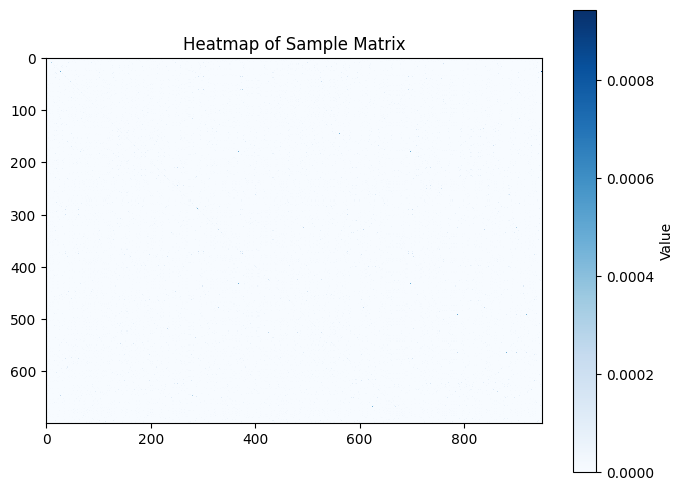

In [22]:
# plot a corner of the heatmap to get a sense for density
# plt.figure(figsize=(8, 6))
# plt.imshow(pi_samp[:100, :100], cmap='Blues', interpolation='nearest')
# plt.colorbar(label='Value')
# plt.title('Heatmap of Sample Matrix')
# plt.show()

In [24]:
# import pickle
# pickle.dump(rna_mod, open(r"data/CITEseq/unbalanced_orig_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(adt_mod, open(r"data/CITEseq/unbalanced_orig_adt_cite_fig.pkl", mode='wb'))
# pickle.dump(pd.DataFrame(aligned_rna, columns=adt_mod.columns, index=rna_mod.index), open(r"data/CITEseq/unbalanced_aligned_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(pi_feat, open(r"data/CITEseq/unbalanced_feat_mtx.pkl", mode='wb'))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

In [79]:
rna_mtx = pickle.load(open("data/CITEseq/unbalanced_orig_rna_cite_fig.pkl", 'rb'))
adt_mtx = pickle.load(open("data/CITEseq/unbalanced_orig_adt_cite_fig.pkl", 'rb'))
aligned_rna = pickle.load(open("data/CITEseq/unbalanced_aligned_rna_cite_fig.pkl", 'rb'))

rna_mtx.shape, adt_mtx.shape, aligned_rna.shape

((700, 25), (950, 25), (700, 25))

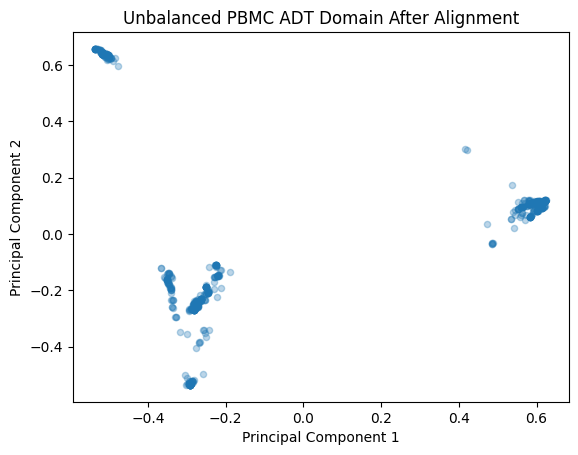

In [80]:
Xadt_integrated=adt_mtx
Yrna_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xadt_integrated,Yrna_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xadt_integrated_pc=concatenated_pc[0:Xadt_integrated.shape[0],:]
Yrna_subsamp_integrated_pc=concatenated_pc[Xadt_integrated.shape[0]:,:]

plt.scatter(Yrna_subsamp_integrated_pc[:, 0], Yrna_subsamp_integrated_pc[:, 1], s=20, alpha=0.3)
    
    
plt.title('Unbalanced PBMC ADT Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


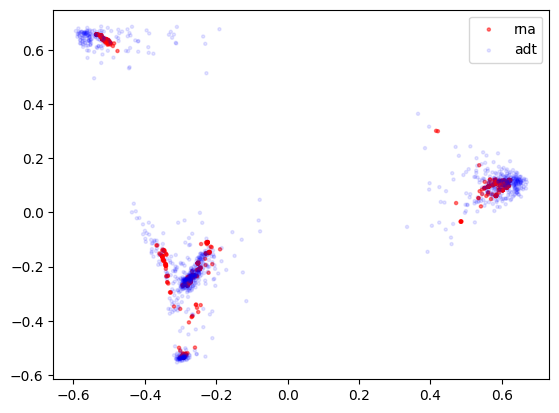

In [40]:
Xadt_integrated=adt_mtx
Yrna_subsamp_integrated=aligned_rna
concatenated=np.concatenate((Xadt_integrated,Yrna_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xadt_integrated_pc=concatenated_pc[0:Xadt_integrated.shape[0],:]
Yrna_subsamp_integrated_pc=concatenated_pc[Xadt_integrated.shape[0]:,:]

rna_labels = np.array(["rna" for _ in range(rna_mod.shape[0])])
adt_labels = np.array(["adt" for _ in range(adt_mod.shape[0])])
alphas = (np.hstack((np.ones_like(adt_labels, dtype=int)/10, np.ones_like(rna_labels, dtype=int)/2)))

for (label, color) in zip(["rna", "adt"], ['r', 'b']):
    mask = (np.hstack((adt_labels, rna_labels)) == label)
    plt.scatter(np.vstack((Xadt_integrated_pc, Yrna_subsamp_integrated_pc))[mask, 0], np.vstack((Xadt_integrated_pc, Yrna_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()


### Unbalanced Feats

In [319]:
# compute new distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_ufrna = compute_graph_distances(rna_feat_mtx.astype('float32'), n_neighbors=100, mode='connectivity')
D_ufadt = compute_graph_distances(adt_feat_mtx.astype('float32'), n_neighbors=100, mode='connectivity')

In [320]:
from scotplus.utils.alignment import get_barycentre, FOSCTTM

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=10)

# original grid search
# scores = pd.Series(index=pd.MultiIndex.from_product([[0.1, 0.15, 0.2, 0.25, 0.3], reversed([x for x in np.logspace(-3, -1, 10)]), [0.01, 0.1]], names=["alpha", "eps", "rho"]), name="FOSCTTM")
# for alpha in [0.1, 0.15, 0.2, 0.25, 0.3]:
#     for rho in [0.01, 0.1]:
#         for eps in reversed([x for x in np.logspace(-3, -1, 10)]):
#             print(alpha, eps, rho)
#             pi_samp,_,pi_feat = scot.uagw(rna_feat_mtx, adt_feat_mtx, D_ufrna, D_ufadt, alpha=alpha, eps = eps, rho=(float('inf'), float('inf'), rho, rho), verbose = False)
#             aligned_rna = get_barycentre(adt_feat_mtx, pi_samp)
#             scores.loc[(alpha, eps, rho)] = np.mean(FOSCTTM(adt_feat_mtx, aligned_rna))
#             print(scores.loc[(alpha, eps, rho)])
# pickle.dump(scores, open(r"data/CITEseq/unbalanced_f_cite_scores_gsearch.pkl", mode='wb'))
scores = pickle.load(open(r"data/CITEseq/unbalanced_f_cite_scores_gsearch.pkl", mode='rb'))
alpha, eps, rho = scores.idxmin()
pi_samp,_,pi_feat = scot.uagw(rna_feat_mtx, adt_feat_mtx, D_ufrna, D_ufadt, alpha=alpha, eps = eps, rho=(float('inf'), float('inf'), rho, rho), verbose = False)
aligned_rna = get_barycentre(adt_feat_mtx, pi_samp)

In [321]:
pickle.load(open(r"data/CITEseq/unbalanced_f_cite_scores_gsearch.pkl", mode='rb')).idxmin()

(0.2, 0.001, 0.1)

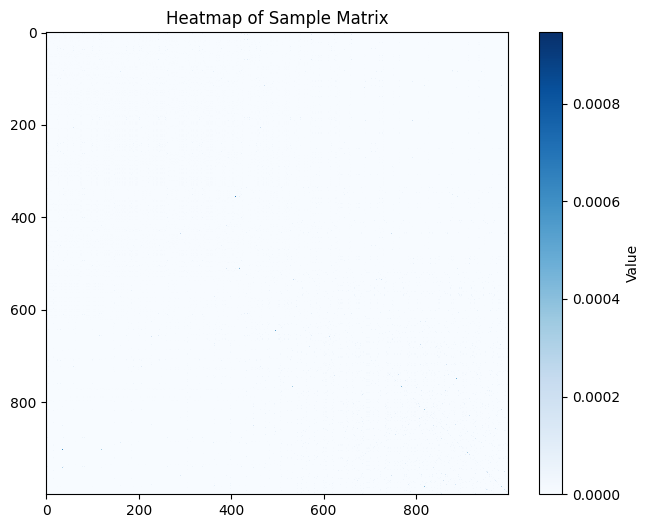

In [30]:
# plot a corner of the heatmap to get a sense for density
# plt.figure(figsize=(8, 6))
# plt.imshow(pi_samp, cmap='Blues', interpolation='nearest')
# plt.colorbar(label='Value')
# plt.title('Heatmap of Sample Matrix')
# plt.show()

In [32]:
# import pickle
# pickle.dump(rna_feat_mod, open(r"data/CITEseq/unbalanced_f_orig_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(adt_feat_mod, open(r"data/CITEseq/unbalanced_f_orig_adt_cite_fig.pkl", mode='wb'))
# pickle.dump(pd.DataFrame(aligned_rna, columns=adt_feat_mod.columns, index=rna_feat_mod.index), open(r"data/CITEseq/unbalanced_f_aligned_rna_cite_fig.pkl", mode='wb'))
# pickle.dump(pi_feat, open(r"data/CITEseq/unbalanced_f_feat_mtx.pkl", mode='wb'))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

In [33]:
rna_feat_mtx = pickle.load(open("data/CITEseq/unbalanced_f_orig_rna_cite_fig.pkl", 'rb'))
adt_feat_mtx = pickle.load(open("data/CITEseq/unbalanced_f_orig_adt_cite_fig.pkl", 'rb'))
aligned_rna = pickle.load(open("data/CITEseq/unbalanced_f_aligned_rna_cite_fig.pkl", 'rb'))
pi_feat = pickle.load(open("data/CITEseq/unbalanced_f_feat_mtx.pkl", 'rb'))

rna_feat_mtx.shape, adt_feat_mtx.shape, aligned_rna.shape

((1000, 17), (1000, 22), (1000, 22))

<Axes: >

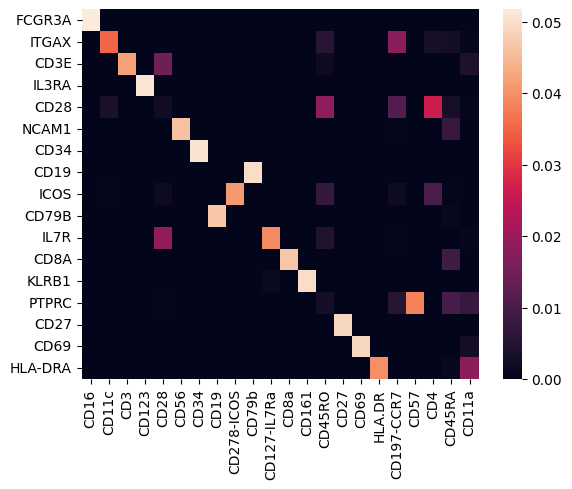

In [323]:
import seaborn as sns
sns.heatmap(pd.DataFrame(pi_feat, index=rna_feat_mod.columns, columns=adt_feat_mod.columns))

### Systematically Unbalanced Feats

In [ ]:
# compute new distance matrices
from scotplus.utils.alignment import compute_graph_distances
D_sufrna = compute_graph_distances(rna_sfeat_mtx.astype('float32'), n_neighbors=100, mode='connectivity')
D_sufadt = compute_graph_distances(adt_sfeat_mtx.astype('float32'), n_neighbors=100, mode='connectivity')

In [350]:
from scotplus.utils.alignment import get_barycentre, FOSCTTM

scot = SinkhornSolver(tol_uot=1e-5, nits_uot=int(1e4), nits_bcd=10)

# original grid search
# scores = pd.Series(index=pd.MultiIndex.from_product([[0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.8], [0.002, 0.001, 0.0005], [0.005, 0.01, 0.02], [50, 100, 150]], names=["alpha", "eps", "rho", "k"]), name="FOSCTTM")

# for k in [50, 100, 150]:
#     D_sufrna = compute_graph_distances(rna_sfeat_mtx.astype('float32'), n_neighbors=k, mode='connectivity')
#     D_sufadt = compute_graph_distances(adt_sfeat_mtx.astype('float32'), n_neighbors=k, mode='connectivity')
#     for alpha in [0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.8]:
#         for rho in [0.005, 0.01, 0.02]:
#             for eps in [0.002, 0.001, 0.0005]:
#                 print(alpha, eps, rho, k)
#                 pi_samp,_,pi_feat = scot.uagw(rna_sfeat_mtx, adt_sfeat_mtx, D_sufrna, D_sufadt, alpha=alpha, eps = eps, rho=(float('inf'), float('inf'), rho, rho), verbose = False)
#                 aligned_rna = get_barycentre(adt_sfeat_mtx, pi_samp)
#                 scores.loc[(alpha, eps, rho, k)] = np.mean(FOSCTTM(adt_sfeat_mtx, aligned_rna))
#                 print(scores.loc[(alpha, eps, rho, k)])
# pickle.dump(scores, open(r"data/CITEseq/unbalanced_sf_cite_scores_gsearch.pkl", mode='wb'))
# scores = pickle.load(open(r"data/CITEseq/unbalanced_sf_cite_scores_gsearch.pkl", mode='rb'))
# curr figure
alpha, eps, rho, k = (0.1, (0.002, 0.001), 0.005, 100)

# curr exp
# alpha, eps, rho, k = (0.05, (0.002, 0.002), 0.01, 120)

D_sufrna = compute_graph_distances(rna_sfeat_mtx.astype('float32'), n_neighbors=k, mode='connectivity')
D_sufadt = compute_graph_distances(adt_sfeat_mtx.astype('float32'), n_neighbors=k, mode='connectivity')

# try nit bcd = 2
pi_samp,_,pi_feat = scot.uagw(rna_sfeat_mtx, adt_sfeat_mtx, D_sufrna, D_sufadt, alpha=alpha, eps = eps, rho=(float('inf'), float('inf'), rho, rho), verbose = True, beta=(0, 0.01), D=(np.ones((1000, 1000)).astype('float32'), np.vstack((np.ones((20,20))-np.eye(20), np.ones((5, 20)))).astype('float32')), nits_gw=1)
aligned_rna = get_barycentre(adt_sfeat_mtx, pi_samp)

BCD Iteration 1 - Loss: 0.022523, 0.024447
BCD Iteration 2 - Loss: 0.013828, 0.015942
BCD Iteration 3 - Loss: 0.014045, 0.016455
BCD Iteration 4 - Loss: 0.014236, 0.016727
BCD Iteration 5 - Loss: 0.013957, 0.016541
BCD Iteration 6 - Loss: 0.014086, 0.016725
BCD Iteration 7 - Loss: 0.014079, 0.016737
BCD Iteration 8 - Loss: 0.014005, 0.016693
BCD Iteration 9 - Loss: 0.013932, 0.016666
BCD Iteration 10 - Loss: 0.013953, 0.016712


In [237]:
scores = pickle.load(open(r"data/CITEseq/unbalanced_sf_cite_scores_gsearch.pkl", mode='rb'))

In [238]:
scores.idxmin()

(0.3, 0.002, 0.005, 50)

In [156]:
scores.min()

alpha  eps     rho    k  
0.1    0.0020  0.005  50     0.110467
                      100         NaN
                      150         NaN
               0.010  50     0.118563
                      100         NaN
                               ...   
0.8    0.0005  0.010  100         NaN
                      150         NaN
               0.020  50          NaN
                      100         NaN
                      150         NaN
Name: FOSCTTM, Length: 189, dtype: float64

In [68]:
# plot a corner of the heatmap to get a sense for density
# plt.figure(figsize=(8, 6))
# plt.imshow(pi_samp, cmap='Blues', interpolation='nearest')
# plt.colorbar(label='Value')
# plt.title('Heatmap of Sample Matrix')
# plt.show()

In [263]:
import pickle
pickle.dump(rna_sfeat_mod, open(r"data/CITEseq/unbalanced_sf_orig_rna_cite_fig.pkl", mode='wb'))
pickle.dump(adt_sfeat_mod, open(r"data/CITEseq/unbalanced_sf_orig_adt_cite_fig.pkl", mode='wb'))
pickle.dump(pd.DataFrame(aligned_rna, columns=adt_sfeat_mod.columns, index=rna_sfeat_mod.index), open(r"data/CITEseq/unbalanced_sf_aligned_rna_cite_fig.pkl", mode='wb'))
pickle.dump(pi_feat, open(r"data/CITEseq/unbalanced_sf_feat_mtx.pkl", mode='wb'))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

In [26]:
rna_sfeat_mtx = pickle.load(open("data/CITEseq/unbalanced_sf_orig_rna_cite_fig.pkl", 'rb'))
adt_sfeat_mtx = pickle.load(open("data/CITEseq/unbalanced_sf_orig_adt_cite_fig.pkl", 'rb'))
aligned_rna = pickle.load(open("data/CITEseq/unbalanced_sf_aligned_rna_cite_fig.pkl", 'rb'))
pi_feat = pickle.load(open("data/CITEseq/unbalanced_sf_feat_mtx.pkl", 'rb'))

rna_sfeat_mtx.shape, adt_sfeat_mtx.shape, aligned_rna.shape

((1000, 25), (1000, 20), (1000, 20))

0.0916036036036036
tensor(0.5158)


<Axes: >

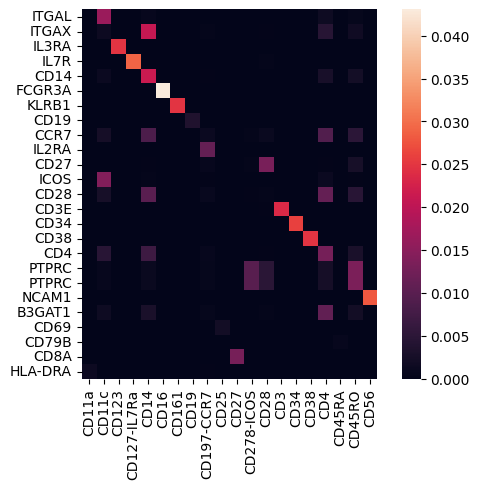

In [27]:
import seaborn as sns
import numpy as np
print(np.mean(FOSCTTM(adt_sfeat_mtx, aligned_rna)))
print(np.sum(np.diag(pi_feat[:20, :20]))/pi_feat.sum())
sns.heatmap(pd.DataFrame(pi_feat, index=rna_sfeat_mod.columns, columns=adt_sfeat_mod.columns), square=True)